In [1]:
import numpy as np
import pandas as pd

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
        
import cv2
import random
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from sklearn.metrics import f1_score
from keras.optimizers import RMSprop,Adam
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
base_data_dir = "/kaggle/input/leapgestrecog/leapGestRecog"
gestures = ["01_palm", "02_l", "03_fist", "04_fist_moved", "05_thumb", "06_index", "07_ok", "08_palm_moved", "09_c", "10_down"]
data = []
image_size = (50, 50)

for subject in range(10):
    subject_data_dir = os.path.join(base_data_dir, f"{subject:02d}")
    for gesture in gestures:
        gesture_dir = os.path.join(subject_data_dir, gesture)
        if os.path.exists(gesture_dir):
            for filename in os.listdir(gesture_dir):
                if filename.endswith(".png"):
                    image_path = os.path.join(gesture_dir, filename)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    resized_image = cv2.resize(image, image_size)
                    data.append({"gesture": gesture, "image": resized_image})

total_data_count = len(data)
print(f"Toplam veri sayısı: {total_data_count}")

Toplam veri sayısı: 20000


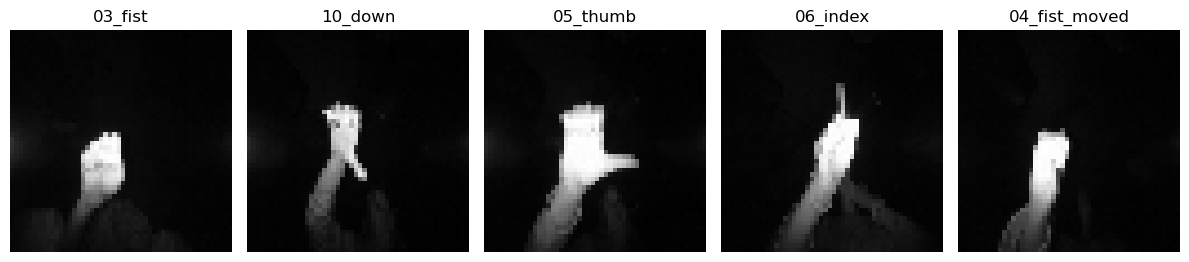

In [3]:
num_samples_to_display = 5
plt.figure(figsize=(12, 8))

for i in range(num_samples_to_display):
    random_index = random.randint(0, len(data) - 1)
    sample = data[random_index]
    gesture = sample['gesture']
    image = sample['image']
    
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(gesture)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
df = pd.DataFrame(data)
X_train = np.array(df['image'].tolist())

X_train = X_train.reshape(-1, 50, 50, 1)
X_train = X_train / 255.0

Y_train = df['gesture']

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: (20000, 50, 50, 1)
Y_train shape: (20000,)


In [5]:
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(Y_train)

onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_labels = onehot_encoder.fit_transform(numerical_labels.reshape(-1, 1))

X_train, X_val, onehot_labels_train, onehot_labels_val = train_test_split(X_train, onehot_labels, test_size=0.1, random_state=2)

In [6]:
model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (50,50,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [7]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

epochs = 10
batch_size = 250

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [8]:
history = model.fit(X_train, onehot_labels_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_val, onehot_labels_val))

Epoch 1/10
72/72 [==============================] - 20s 258ms/step - loss: 1.3168 - accuracy: 0.5606 - val_loss: 0.4972 - val_accuracy: 0.8760
Epoch 2/10
72/72 [==============================] - 19s 259ms/step - loss: 0.4439 - accuracy: 0.8558 - val_loss: 0.1415 - val_accuracy: 0.9755
Epoch 3/10
72/72 [==============================] - 19s 259ms/step - loss: 0.2217 - accuracy: 0.9292 - val_loss: 0.0463 - val_accuracy: 0.9950
Epoch 4/10
72/72 [==============================] - 18s 253ms/step - loss: 0.1315 - accuracy: 0.9606 - val_loss: 0.0255 - val_accuracy: 0.9975
Epoch 5/10
72/72 [==============================] - 19s 259ms/step - loss: 0.0903 - accuracy: 0.9741 - val_loss: 0.0114 - val_accuracy: 0.9990
Epoch 6/10
72/72 [==============================] - 18s 253ms/step - loss: 0.0682 - accuracy: 0.9795 - val_loss: 0.0081 - val_accuracy: 0.9995
Epoch 7/10
72/72 [==============================] - 19s 260ms/step - loss: 0.0577 - accuracy: 0.9833 - val_loss: 0.0056 - val_accuracy: 0.9995

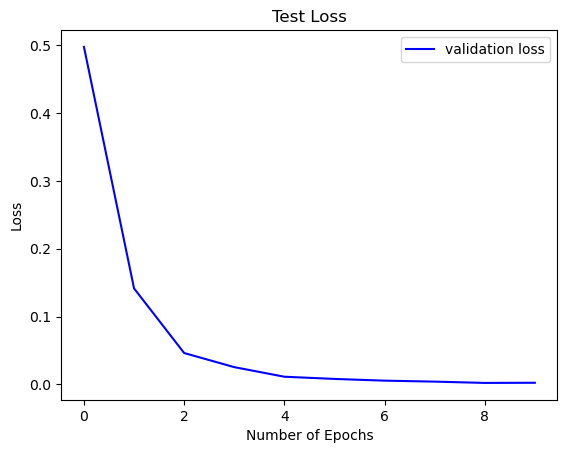

In [9]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
Y_pred = model.predict(X_val) 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(onehot_labels_val ,axis = 1) 

63/63 [==============================] - 1s 12ms/step


In [11]:
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f"F1 Puanı: {f1:.4f}")

F1 Puanı: 0.9995


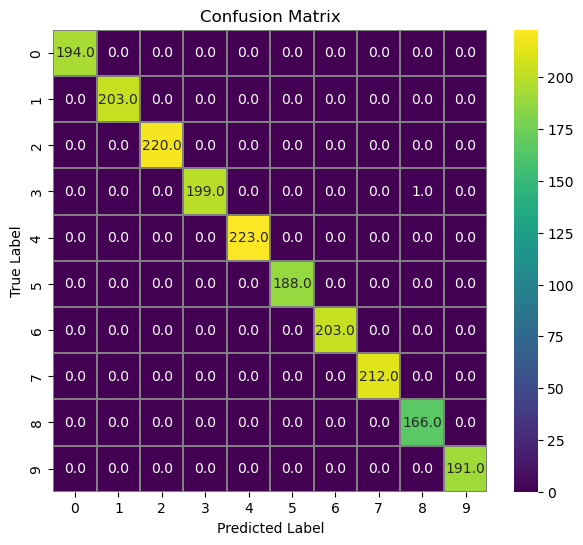

In [12]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(7, 6))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="viridis",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

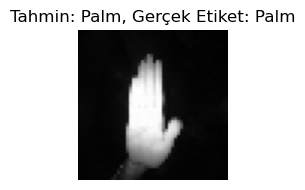

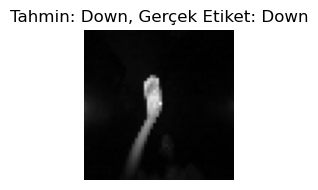

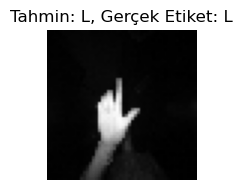

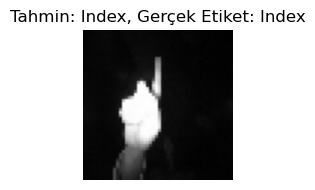

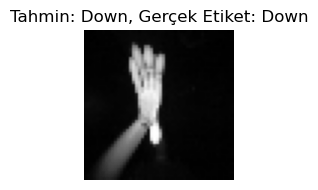

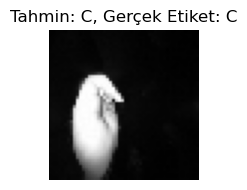

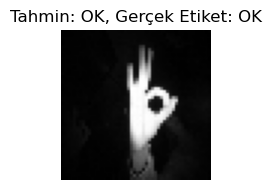

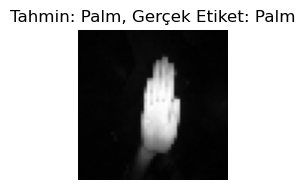

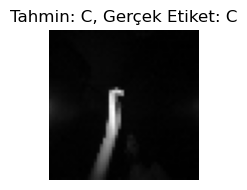

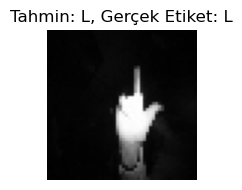

In [13]:
label_encoder = LabelEncoder()
label_encoder.fit(Y_true)

inverted_true = label_encoder.inverse_transform(Y_true)
inverted_pred = label_encoder.inverse_transform(Y_pred_classes)

label_map = {0: 'Palm', 1: 'L', 2: 'Fist', 3: 'Fist Moved', 4: 'Thumb', 5: 'Index', 6: 'OK', 7: 'Palm Moved', 8: 'C', 9: 'Down'}

inverted_true_names = [label_map.get(label, label) for label in inverted_true]
inverted_pred_names = [label_map.get(label, label) for label in inverted_pred]

sample_indices = np.random.choice(len(X_val), size=10, replace=False)

for idx in sample_indices:
    plt.figure(figsize=(3, 2))

    plt.imshow(X_val[idx].reshape(50, 50), cmap='gray')
    plt.title(f"Tahmin: {inverted_pred_names[idx]}, Gerçek Etiket: {inverted_true_names[idx]}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()